## NVT simulation of 2 particles interacting via Morse potential in a LJ fluid in 2 dimensions.

In [ ]:
## Run this with colab
%%capture
#@title Imports & Utils

!pip install jax-md

In [22]:
# Credits
# NVT Simulation.ipynb from JAX MD and JAX MD documentation

from jax import numpy as np
import numpy as onp
from jax import random, jit, lax, ops, grad
from jax_md import space, smap, energy, minimize, quantity, simulate
from jax.config import config ; config.update('jax_enable_x64', True)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### helper functions adapted from [JAX MD NVT simulation tutorial](https://colab.research.google.com/github/google/jax-md/blob/main/notebooks/nvt_simulation.ipynb) 

In [6]:
sns.set_style(style='white')

def format_plot(x, y):  
    plt.xlabel(x, fontsize=20)
    plt.ylabel(y, fontsize=20)
    
def finalize_plot(shape=(1, 1)):
    plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
    plt.tight_layout()
    
def plot_system(R,box_size,species=None,ms=20):
    R_plt = onp.array(R)

    if(species is None):
        plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
    else:
        for ii in range(np.amax(species)+1):
            Rtemp = R_plt[species==ii]
            plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

    plt.xlim([0, box_size])
    plt.ylim([0, box_size])
    plt.xticks([], [])
    plt.yticks([], [])

    finalize_plot((1,1))

### Define system parameters

In [7]:
N = 400 # number of particles
dimension = 2
density = 0.84
box_size = quantity.box_size_at_number_density(N, density, dimension)
dt = 5e-3
displacement, shift = space.periodic(box_size) 
kT = 0.8 # temperature

### Generate initial positions

In [8]:
key = random.PRNGKey(0)
key, split = random.split(key)
R = box_size * random.uniform(split, (N, dimension), dtype=np.float64)

### Define energy function for 2 particles system interacting via Morse potential in a LJ fluid.

In [9]:
particles_index = [0, 10]
# The is a 2 particles system interacting via Morse potential in a LJ fluid.
def total_energy_fn(R, **kwargs):
    
    particles_index = kwargs.get('particles_index')
    
    #print("particles index")
    #print(particles_index)
    
    epsilon = np.ones((N, N))
    epsilon = epsilon.at[particles_index[0],particles_index[1]].set(0.)
    epsilon = epsilon.at[particles_index[1],particles_index[0]].set(0.)
    
    solvent_energy_fn = energy.lennard_jones_pair(displacement, sigma=1.0, epsilon=epsilon, r_cutoff=2.5)
    
    epsilon = np.zeros((N, N))
    particles_index = [0, 10]
    epsilon = epsilon.at[particles_index[0],particles_index[1]].set(5.)
    epsilon = epsilon.at[particles_index[1],particles_index[0]].set(5.)

    particle_energy_fn = energy.morse_pair(displacement, sigma=1.0, epsilon=epsilon, alpha=5.0, r_cutoff=2.5)
    
    return particle_energy_fn(R) + solvent_energy_fn(R)

### Run energy minimization

In [13]:
def run_minimization(energy_fn, R_init, shift, num_steps=5000, particles_index=None):
    dt_start = 0.001
    dt_max   = 0.004
    init,apply = minimize.fire_descent(jit(energy_fn),shift,dt_start=dt_start,dt_max=dt_max)
    apply = jit(apply)

    @jit
    def scan_fn(state, i):
        return apply(state, particles_index=particles_index), 0.

    state = init(R_init, particles_index=particles_index)
    state, _ = lax.scan(scan_fn,state,np.arange(num_steps))

    return state.position, np.amax(np.abs(-grad(total_energy_fn)(state.position, particles_index=particles_index)))

### Print energy minimization results

In [14]:
Rfinal, max_force_component = run_minimization(total_energy_fn, R, shift, particles_index=particles_index)
print('largest component of force after minimization = {}'.format(max_force_component))

largest component of force after minimization = 0.4716959164624689


### Visualize energy minimized configuration

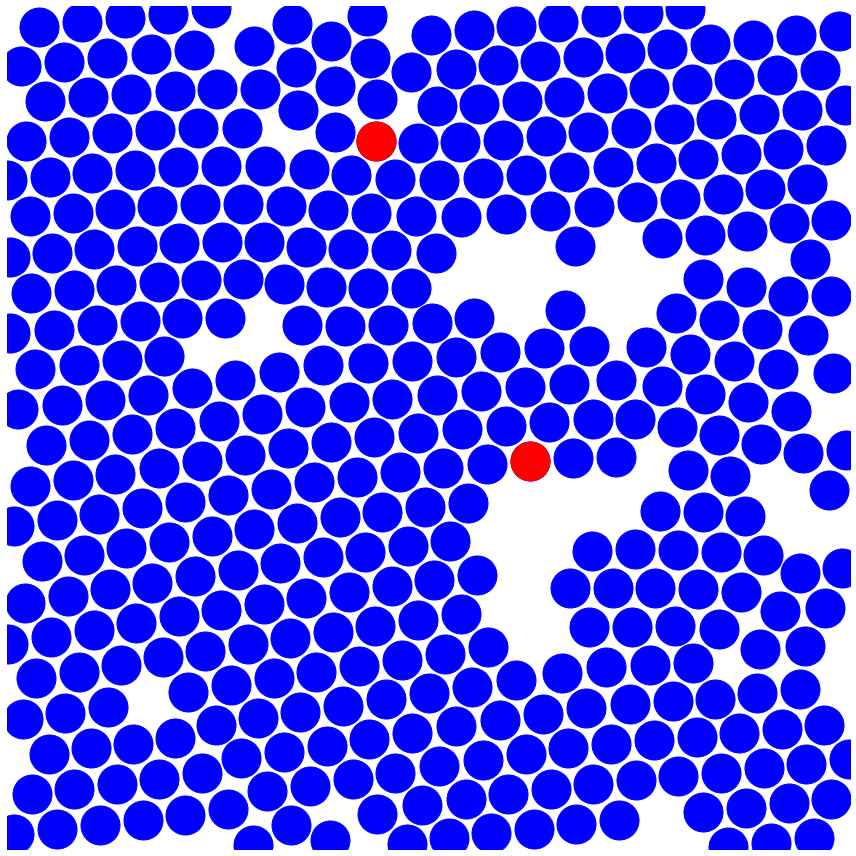

In [15]:
ms = 65
R_plt = Rfinal

#plt.plot(R_plt, R_plt, 'o', markersize=ms * 1)
#plot_system(Rfinal, box_size)
plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms * 0.6, color='blue')
plt.plot(R_plt[particles_index[0]][0], R_plt[particles_index[0]][1], 'o', markersize=ms * 0.6, color='red')
plt.plot(R_plt[particles_index[1]][0], R_plt[particles_index[1]][1], 'o', markersize=ms * 0.6, color='red')

#plt.xlim([0, np.max(R[:, 0])])
#plt.ylim([0, np.max(R[:, 1])])

plt.xlim([0, box_size])
plt.ylim([0, box_size])

plt.axis('off')

finalize_plot((2, 2))

### Function to integrate using Nose Hoover thermostat

In [16]:
write_every = 100

def step_fn(i, state_and_log, particles_index=particles_index):
    state, log, particles_index = state_and_log

    t = i * dt

    # Log information about the simulation.
    # NOTE: Warning: As of v0.2.0 the internal representation of JAX MD simulations 
    # has changed from velocity to momentum. For the most part this should not affect your work, 
    # but the inputs to quantity.kinetic_energy and quantity.temperature have changed 
    # from taking velocity to momentum!
    
    # NOTE: v0.2.0 is not released officially yet!

    T = quantity.temperature(velocity=state.velocity) # this line changes in v0.2.0
    log['kT'] = log['kT'].at[i].set(T)
    H = simulate.nvt_nose_hoover_invariant(total_energy_fn, state, kT, particles_index=particles_index)
    log['H'] = log['H'].at[i].set(H)
    # Record positions every `write_every` steps.
    log['position'] = lax.cond(i % write_every == 0,
                                lambda p: \
                                p.at[i // write_every].set(state.position),
                                lambda p: p,
                                log['position'])

    # Take a simulation step.
    state = apply(state, particles_index=particles_index) # kT=kT)
    
    return state, log, particles_index

### Initialize state using energy minimized configuration

In [17]:
state = Rfinal
init, apply = simulate.nvt_nose_hoover(total_energy_fn, shift, dt, kT)
state = init(key, Rfinal, particles_index=particles_index)

### Run simulation

In [18]:
steps = 10000

log = {
    'kT': np.zeros((steps,)),
    'H': np.zeros((steps,)),
    'position': np.zeros((steps // write_every,) + R.shape) 
}

state, log, particles_index = lax.fori_loop(0, steps, step_fn, (state, log, particles_index))

### Visualize total energy during the simulation

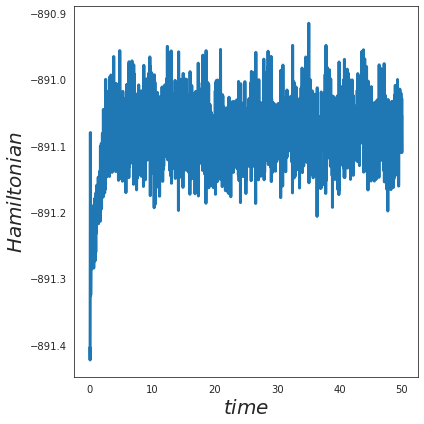

In [19]:
t = onp.arange(0, steps) * dt
plt.plot(t, log['H'], linewidth=3)
format_plot('$time$', '$Hamiltonian$')
finalize_plot()

### Visualize final state

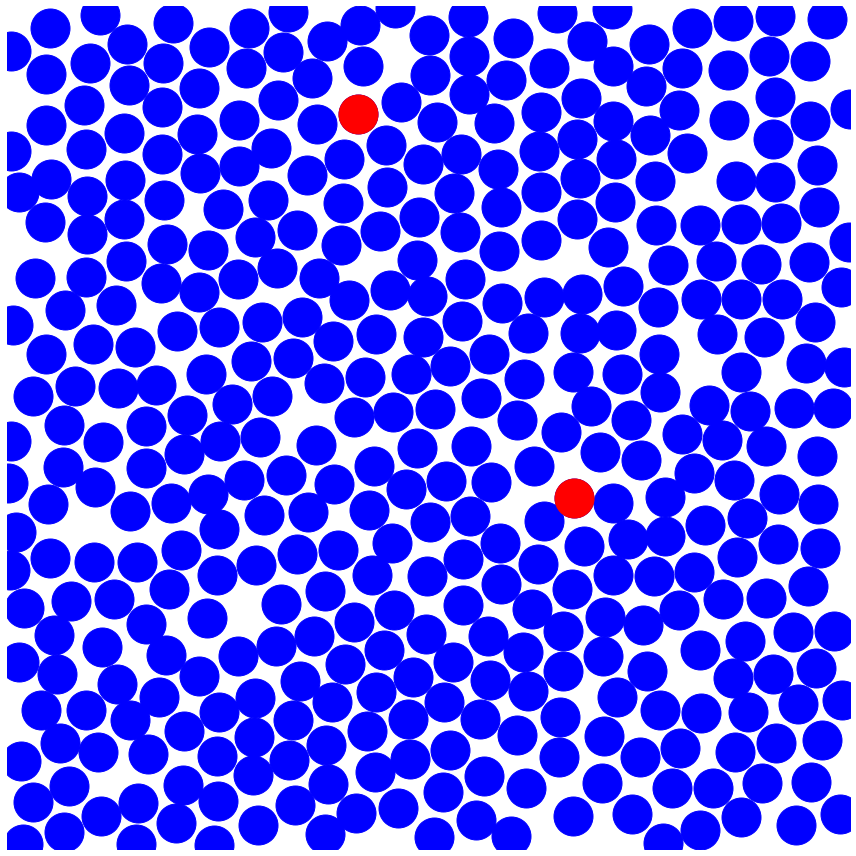

In [20]:
ms = 65
R_plt = onp.array(state.position)

plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms * 0.6, color='blue')
plt.plot(R_plt[particles_index[0]][0], R_plt[particles_index[0]][1], 'o', markersize=ms * 0.6, color='red')
plt.plot(R_plt[particles_index[1]][0], R_plt[particles_index[1]][1], 'o', markersize=ms * 0.6, color='red')

plt.xlim([0, box_size])
plt.ylim([0, box_size])

plt.axis('off')

finalize_plot((2, 2))

### Visualize trajectory in Jupyter notebook (required: [nglview](https://anaconda.org/conda-forge/nglview))

In [24]:
# Credits
# [nglview issue#948 comment #817704693](https://github.com/nglviewer/nglview/issues/948#issuecomment-817704693)

def show_numpy_trajectory(traj, box, aspect_ratio=50):
    """Show Numpy trajectory with constant box.
    
    All atoms will be shown as argon atoms.
    
    Keyword arguments:
    traj -- Numpy array with shape (n_steps, 2, n_atoms) containing positions in reduced units
    box -- Numpy array with shape (2) in reduced units
    aspect_ratio -- parameter chaning the sphere size
    
    Returns:
    nglview.widget.NGLWidget
    """
    # create an argon topology
    top = md.Topology()
    chain = top.add_chain()
    for i in range(traj.shape[1]):
        residue = top.add_residue('AR', chain)
        top.add_atom('Ar', md.element.argon, residue)
    # create trajectory
    n_frames = len(traj)
    t = md.Trajectory(traj, topology=top,
                      unitcell_lengths=np.repeat(box[np.newaxis, ...], n_frames, axis=0),
                      unitcell_angles=np.ones((n_frames, 3))*90.0)
    # create view and show trajectory
    view = nv.show.show_mdtraj(t)
    view.clear_representations()
    view.add_representation('ball+stick', aspectRatio=aspect_ratio)
    view.add_unitcell()
    return view


traj = onp.array(log['position'])
traj = np.concatenate((traj, (box_size/2)*np.ones((traj.shape[0], traj.shape[1], 1), dtype=traj.dtype)), axis=2)
box = np.repeat(box_size, 3)

# enable only for Jupyter notebook
#show_numpy_trajectory(traj, onp.array(box))

### Visualize trajectory in colab

In [44]:
from jax_md.colab_tools import renderer

diameters = 0.4 # sigma[species, species]
diameters = np.ones((N))*np.array([0.5])
diameters = diameters.at[particles_index[0]].set(0.8)
diameters = diameters.at[particles_index[1]].set(0.8)
colors = np.ones((N, 3))*np.array([1.0, 0.5, 0.01])
colors = colors.at[particles_index[0]].set([1,0.2,0.2])
colors = colors.at[particles_index[1]].set([1,0.2,0.2])

renderer.render(box_size,
                {
                    'particles': renderer.Disk(log['position'], 
                                               diameters,
                                               colors)
                },
                resolution=(700, 700))